# Regression

In this example, we use the [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/wine+quality) for a first, simple regression task.
These data consist of a range of features such as acidity or sugar levels, pH value, alcohol content, etc. and the aim is to predict a quality score in the range (0,10).
The data originate from the paper: P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553, 2009. [Wine paper](https://www.sciencedirect.com/science/article/pii/S0167923609001377)

Note that the score is based on integer values - therefore, we could treat this either as a regression problem (like we do here), or a a classification problem with (up to) 10 different classes. The original published paper considered a regression approach - we will therefore follow in their footsteps and treat this problem as a regression task.

We focus on red wines here in this example - feel free to explore the white wines as an exercise.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Data
We can load the data directly from the public repository directly (or from the local backup)

In [2]:
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
    sep=';')
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


# Exploratory Data Analysis

First, we want to get a feel for the data and look at the various variables.
In this case, all variables are already in numeric format.

## Univariate analysis
First, we look at some individual variables to get a feel for their distribution.
Let's start by looking at the target variable ("Quality") - as we can see, not all scores are used, there are very few good or bad wines, most wines are average.

***Exercise***
Explore some more variables

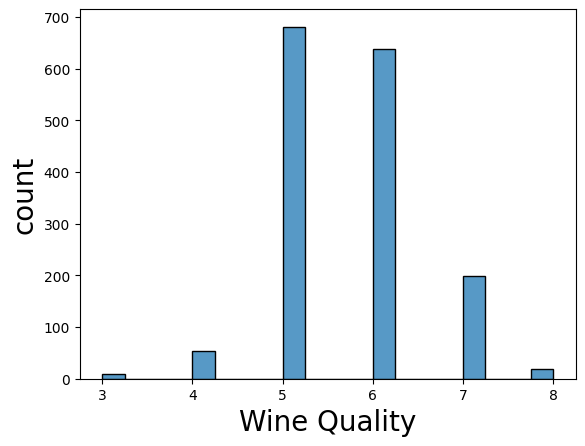

In [4]:
g = sns.histplot(data=df, x='quality',bins=20)
plt.ylabel('count', size = 20)
plt.xlabel('Wine Quality', size = 20)
plt.show()

In [ ]:
##
## explore some more variables
## 

## Explore correlations

Machine learning essentially exploits linear and non-linear correlations between the features and the target (label).
Next, we want to get a feel for how the variables are correlated.
We can first print the correlation table of the variables and then plot the behaviour of individual pairs of variables.
To look at all combinations (or a subset), we can use the [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) from Seaborn, or plot a few individual combinations.

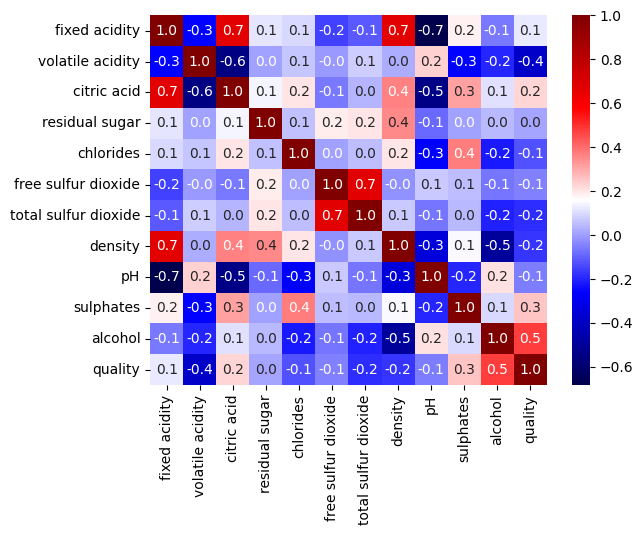

In [6]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap='seismic')
plt.show()

As we can see, some variables are strongly correlated with each other but only three variables have a high correlation with out target: volatile acidity sulphates and alcohol. We will therefore suspect that these variables are the most important for the model.

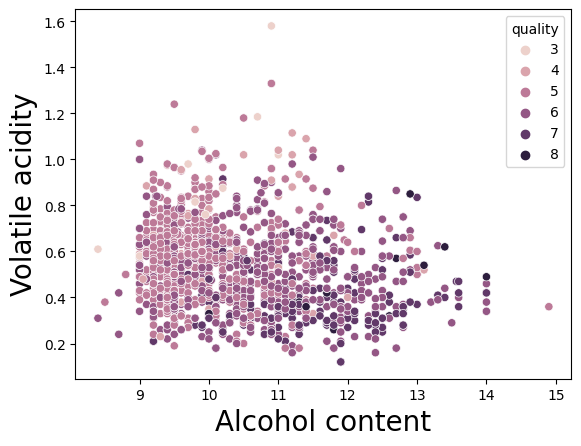

In [7]:
sns.scatterplot(data=df, x='alcohol', y='volatile acidity', hue='quality' )
plt.xlabel('Alcohol content', size = 20)
plt.ylabel('Volatile acidity', size = 20)
plt.show()

***Exercise***

Explore some more correlations between the variables and the target.

In [ ]:
##
## explore some more correlations using plots for two variables liek above or a pairplot
## 

A contour plot in the pair-plot for the 3 main variables shows some dependency - but overall, a visual inspection shows that there is no obvious 1:1 relationship.

# Machine Learning

We now use a machine learning model to predict the quality index.
The model is trained on the training data and then evaluated on predictions made from the independent test data.

We follow the typical Scikit-Learn approach of:
- create an instance of the model
- call the ```fit``` method for the training data
- call the ```predict``` method for the test data.

As an example, we will use the [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

However, first we need to define the training/test data, the features and the labels.

The target (label) is the last column (quality) in the data-frame.

In [10]:
###
### Your code here
###
train_cols = # ...
label = # ...
X = df[train_cols]
y = df[label]

# split into training and test sample
X_train, X_test, y_train, y_test = # ....

In [11]:
#define and fit the model
model = RandomForestRegressor(max_depth=20, random_state=0, n_estimators=15)
model.fit(X_train, y_train)



RandomForestRegressor(max_depth=20, n_estimators=15, random_state=0)

Then, we obtain the predictions on the test data for the model.
For convenience, we make a copy of the test data and append the predictions, together with the true values,  as the last column to the dataframe

In [12]:
predictions = X_test.copy()
y_hat = model.predict(predictions)
predictions.loc[:,'y_hat'] = y_hat
predictions.loc[:,'y'] = y_test
predictions.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,y_hat,y
1552,6.3,0.680,0.01,3.7,0.103,32.0,54.0,0.99586,3.51,0.66,11.3,5.933333,6
1333,9.1,0.775,0.22,2.2,0.079,12.0,48.0,0.99760,3.18,0.51,9.6,5.333333,5
660,7.2,0.520,0.07,1.4,0.074,5.0,20.0,0.99730,3.32,0.81,9.6,5.733333,6
1294,8.2,0.635,0.10,2.1,0.073,25.0,60.0,0.99638,3.29,0.75,10.9,6.066667,6
1339,7.5,0.510,0.02,1.7,0.084,13.0,31.0,0.99538,3.36,0.54,10.5,6.000000,6


# Evaluation

### Global metrics
We now look at a few evaluation metrics.
First we look at some global properties, such as the mean absolute or squared deviation

In [13]:
print('MAD: {0:0.2f}, MSE {1:0.2f}'.format(metrics.mean_absolute_error(y_test, y_hat), 
                                           metrics.mean_squared_error(y_test, y_hat)))


MAD: 0.44, MSE 0.39


### Residuals

We now look at the residuals of the predictions. Ideally, we would expect "Gaussian noise": We do expect that the predictions are not perfect, but there should be no trend and the deviations from the true values (in the test data) should be both as small as possible, as well as randomly distributed.


In [1]:
#display = metrics.PredictionErrorDisplay(y_true=y_test, y_pred=y_hat)
#display.plot()
#plt.show()

### Profile Plot

We can also do a profile plot that illustrates how well the predictions work in various regions. Ideally, the data points on the model should be compatible with the diagonal line for all predictions.



In [2]:

import profile_plot


#fig, ax = plt.subplots(1, 1)
#out = profile_plot.pplot(y_test, y_hat, n_bins=10, yerr='var', ax=ax)
#plt.show()


Think about what this means for our choice of modelling aproach, for the model and what we would need to think about to improve.